In [ ]:
# pipeline

# carregar genoma

# criar reads

# criar os k mears

# fazer o grafo de DeBruijn

# otimizar

# reconstruir o genoma

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

In [ ]:
class Gerenciador_de_Genomas:
    def __init__(self):
        self.bases = ['A', 'C', 'G', 'T']
    def gerar_genoma(self,tamanho, random_state=None):
        random.seed(random_state)
        genoma = ''.join(random.choice(self.bases) for _ in range(tamanho))
        return genoma
    
    def gerar_reads(self,genoma, tamanho_read, cobertura=1.0,temperatura=0,random_state=None):
        reads_totais = [genoma[i:i+random.choice(range(tamanho_read-temperatura,tamanho_read+temperatura+1))]
                        for i in range(len(genoma)-tamanho_read+1)]
        numero_de_reads = int(len(reads_totais)*cobertura)
        random.seed(random_state)
        reads_cobertos = random.sample(reads_totais,numero_de_reads)
        return reads_cobertos
    
    def gerar_kmers(self, reads, k):
        kmers = set()
        for read in reads:
            for i in range(len(read) - k + 1):
                kmear = read[i:i + k]
                kmers.add(kmear)
        return list(kmers)
    
    def gerar_grafo_de_DeBruijn(self, kmers):
        Graph = nx.DiGraph()
        Graph.add_nodes_from(kmers)
        prefixos =  [kmer[:-1] for kmer in kmers]
        sufixos = [kmer[1:] for kmer in kmers]
        for i in range(len(kmers)):
            for j in range(len(kmers)):
                if prefixos[j] == sufixos[i]:
                    Graph.add_edge(kmers[i], kmers[j])
        return Graph

    def desenhar_grafo(self, grafo):
        pos = nx.spring_layout(grafo)
        plt.figure(figsize=(8, 6))
        labels_encurtados = {}
        for node in grafo.nodes():
            if len(node) > 8:
                novo_label = node[:3] + "..." + node[-3:]
            else:
                novo_label = node
            labels_encurtados[node] = novo_label
        nx.draw(grafo, pos, labels=labels_encurtados,
                with_labels=True, node_size=1000,
                node_color='lightblue', font_size=8,
                font_color='black', font_weight='bold',
                arrows=True)

        plt.title("Grafo de De Bruijn")
        plt.show()

    def verificar_se_tem_caminho_euleriano(self,grafo):
        return nx.has_eulerian_path(grafo)
    
    def obter_caminho_euleriano(self,grafo):
        caminho_arestas = list(nx.eulerian_path(grafo))
        caminho = [i[0] for i in caminho_arestas] + [caminho_arestas[-1][1]]
        return caminho
    
    def reconstruir_genoma(self,caminho_euleriano):
        k = len(caminho_euleriano[0])
        novo_genoma = ""
        for i in range(len(caminho_euleriano)):
            if i == 0:
                novo_genoma += caminho_euleriano[i]
            else:
                novo_genoma += caminho_euleriano[i][k-1:]
        return novo_genoma
    
    def comparar_genormas(self,genoma1, genoma2):
        count = 0
        for i in range(len(genoma1)):
            if i > len(genoma2) -1:
                break
            if genoma1[i] == genoma2[i]:
                count +=1
        corr = count/len(genoma1)
        return corr
    
    def fundir_vertices(self,grafo,vertices):
        arestas_de_entrada = set()
        arestas_de_saida = set()
        novo_grafo = grafo.copy()
        for v in vertices:
            arestas_de_entrada = arestas_de_entrada.union(set(grafo.in_edges(v)))
            arestas_de_saida = arestas_de_saida.union(set(grafo.out_edges(v)))
        novo_grafo.remove_nodes_from(vertices)
        nome = self.reconstruir_genoma(vertices)
        arestas_de_entrada = [i for i in list(arestas_de_entrada) if not (i[0] in vertices and i[1] in vertices)]
        arestas_de_saida = [i for i in list(arestas_de_saida) if not (i[0] in vertices and i[1] in vertices)]
        novas_arestas_entrada = [(i[0],nome) for i in arestas_de_entrada]
        novas_arestas_saida = [(nome,i[1]) for i in arestas_de_saida]
        arestas = novas_arestas_entrada + novas_arestas_saida
        novo_grafo.add_node(nome)
        novo_grafo.add_edges_from(arestas)
        return novo_grafo, nome

    def simplificar_grafo(self,grafo, caminho):
        graus_de_entrada = [grafo.in_degree(i) for i in caminho]
        graus_de_saida = [grafo.out_degree(i) for i in caminho]
        pode_fundir = [graus_de_entrada[i]==1 and graus_de_saida[i]==1 for i in range(len(caminho))]
        grupos_de_fusao = []
        sec = 0
        for i in range(len(pode_fundir)):
            if pode_fundir[i]:
                sec +=1
                if sec ==1:
                    grupos_de_fusao.append([caminho[i]])
                else:
                    grupos_de_fusao[-1].append(caminho[i])
            else:
                sec = 0
        novo_grafo = grafo.copy()
        novos_nomes = []
        for i in grupos_de_fusao:
            novo_grafo,novo_nome = self.fundir_vertices(novo_grafo,i)
            novos_nomes.append(novo_nome)
        return novo_grafo,novos_nomes

Genoma Original: GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGTC
Caminho: ['GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACG', 'GAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGA', 'AAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGAC', 'AATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACT', 'ATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTT', 'TACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTC', 'ACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCC', 'CCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCT', 'CATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTT', 'ATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTG', 'TTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGC', 'TTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCA', 'TCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCAC', 'CTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACT', 'TAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTC', 'AAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCT', 'AGTCCGG

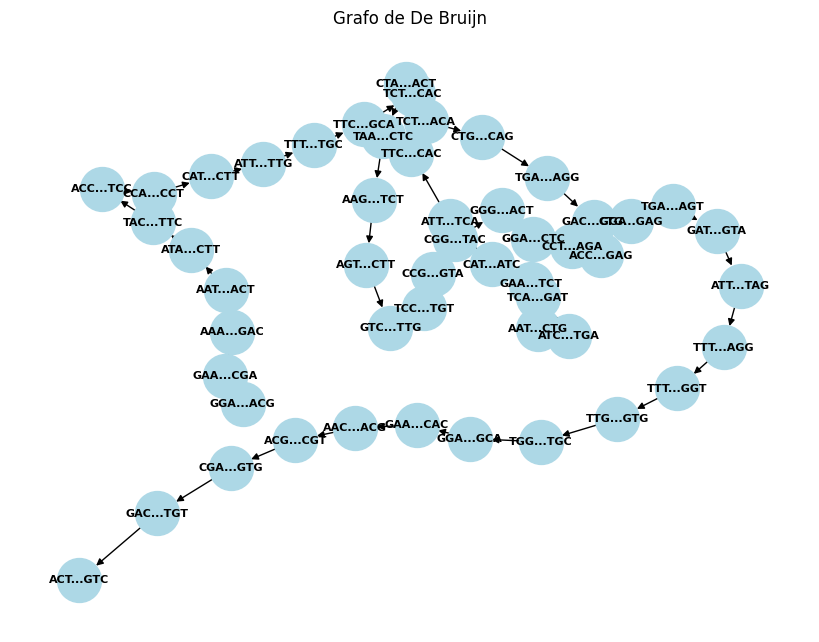

Tempo de execução: 0.47 segundos


In [3]:
start = time.time()
manager = Gerenciador_de_Genomas()
genoma_teste = manager.gerar_genoma(100, random_state=None)
print(f"Genoma Original: {genoma_teste}")
reads_teste = manager.gerar_reads(genoma_teste, tamanho_read=70,cobertura=1)
kmers_teste = manager.gerar_kmers(reads_teste, k=50)
grafo = manager.gerar_grafo_de_DeBruijn(kmers_teste)
if manager.verificar_se_tem_caminho_euleriano(grafo):
    caminho = manager.obter_caminho_euleriano(grafo)
    print(f"Caminho: {caminho}")
    genoma1 = manager.reconstruir_genoma(caminho)
    print(f"Genoma final: {genoma1}")
    manager.desenhar_grafo(grafo)
else:
    print("Grafo invalido")
print(f"Tempo de execução: {round(time.time() - start,2)} segundos")

Caminho: ['GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACG', 'GAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGT', 'ACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGTC']
Genoma final: GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGTC


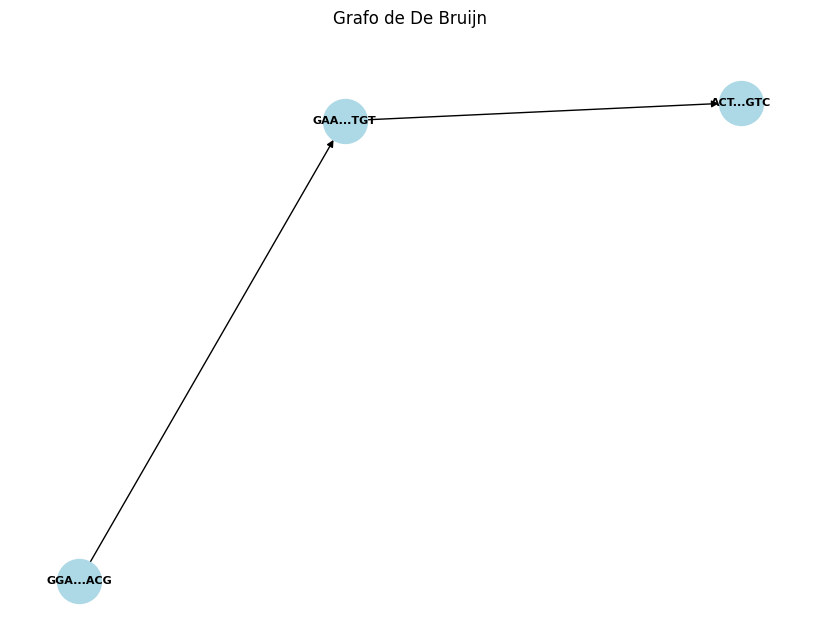

In [4]:
grafo2,nomes = manager.simplificar_grafo(grafo,caminho)
if manager.verificar_se_tem_caminho_euleriano(grafo2):
    caminho2 = manager.obter_caminho_euleriano(grafo2)
    print(f"Caminho: {caminho2}")
    genoma2 = manager.reconstruir_genoma(caminho2)
    print(f"Genoma final: {genoma2}")
    manager.desenhar_grafo(grafo2)
else:
    print("Grafo invalido")

In [5]:
print(genoma_teste)
print(genoma1)
print(genoma2)
corr = manager.comparar_genormas(genoma_teste,genoma1)
print(f"O genoma gerado 1 tem {round(100*corr,2)}% de encaixe com o genoma original")
corr = manager.comparar_genormas(genoma_teste,genoma2)
print(f"O genoma gerado 2 tem {round(100*corr,2)}% de encaixe com o genoma original")


GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGTC
GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGTC
GGAAATACCATTTCTAAGTCCGGGAATCATTCTGACCTGATTTTGGAACGACTTCCTTGCACTCTTGTACTCTGATCACAGGAGAGTAGGTGCACGTGTC
O genoma gerado 1 tem 100.0% de encaixe com o genoma original
O genoma gerado 2 tem 100.0% de encaixe com o genoma original


In [6]:
# gerando massa de dados
genomas = [manager.gerar_genoma(i) for i in [8,80,800,8000,80000]]
for i in genomas:
    with open(f"./test_data/teste_tamanho_{len(i)}.txt", "w") as arquivo:
        arquivo.write(i)

In [37]:
manager = Gerenciador_de_Genomas()
def recombinacao_genetica(genoma,tamanho_read,k):
    start = time.time()
    print(f"Tamanho do Genoma Original: {len(genoma)}")
    reads = manager.gerar_reads(genoma, tamanho_read,cobertura=1)
    print(f"Foram gerados {len(reads)} reads de tamanho {tamanho_read}")
    kmers = manager.gerar_kmers(reads, k)
    print(f"Foram gerados {len(reads)} k-mers de tamanho {k}")
    grafo = manager.gerar_grafo_de_DeBruijn(kmers)
    if manager.verificar_se_tem_caminho_euleriano(grafo):
        caminho = manager.obter_caminho_euleriano(grafo)
        genoma1 = manager.reconstruir_genoma(caminho)
        print(f"Genoma final: {genoma1}")
        end = time.time()-start
        print(f"Tempo de execução: {round(end,4)} segundos")
        # grafo_simplificado,_= manager.simplificar_grafo(grafo,caminho)
        # caminho_simplificado = manager.obter_caminho_euleriano(grafo_simplificado)
        # genoma1_simplificado = manager.reconstruir_genoma(caminho_simplificado)
        return grafo, genoma1, grafo, end
    else:
        print("O grafo não possui caminho Euleriano")

def ler_genoma(file):
    with open(file, "r") as f:
        genoma = f.read().replace("\n", "")
    return genoma

In [38]:
genoma1 = ler_genoma("./test_data/teste_tamanho_8.txt")
genoma2 = ler_genoma("./test_data/teste_tamanho_80.txt")
genoma3 = ler_genoma("./test_data/teste_tamanho_800.txt")
genoma4 = ler_genoma("./test_data/teste_tamanho_8000.txt")
genoma5 = ler_genoma("./test_data/teste_tamanho_80000.txt")
genoma_real = ler_genoma("./test_data/genoma_escherichia_phage.txt")

Tamanho do Genoma Original: 8
Foram gerados 1 reads de tamanho 8
Foram gerados 1 k-mers de tamanho 4
Genoma final: AGCATCAG
Tempo de execução: 0.001 segundos
--------------------------------------------------
O genoma reconstruido teve 100.0% de correspondência com o genoma original
--------------------------------------------------
Grafo Completo


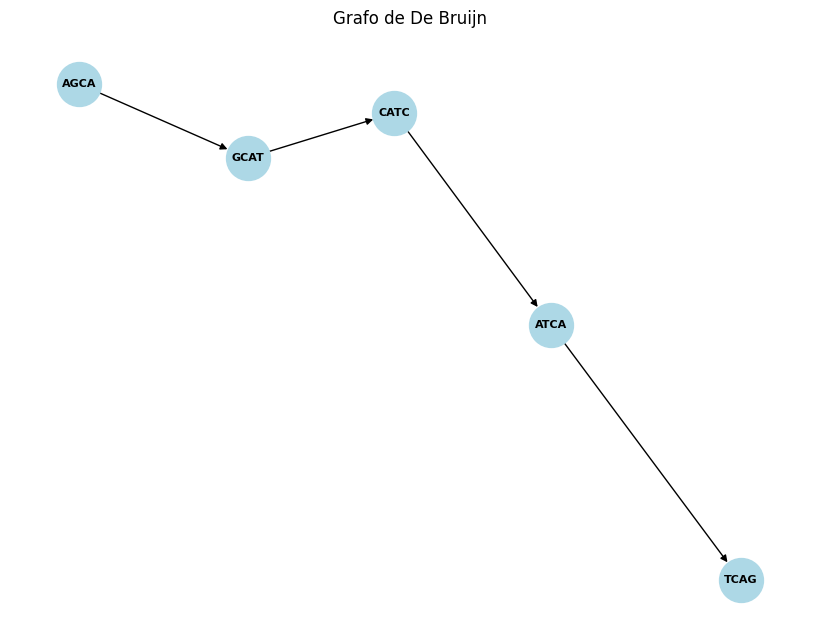

AGCATCAG
Grafo Simplificado


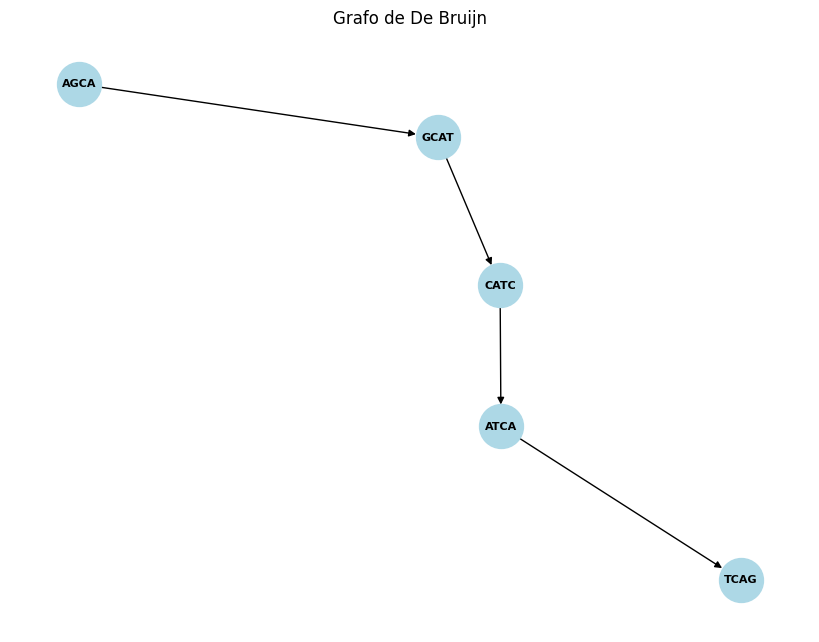

In [46]:
grafo, genoma, grafo_simplificado,tempo = recombinacao_genetica(genoma1,8,4)
print("-"*50)
corr = manager.comparar_genormas(genoma1,genoma)
print(f"O genoma reconstruido teve {round(corr*100,2)}% de correspondência com o genoma original")
print("-"*50)
print("Grafo Completo")
manager.desenhar_grafo(grafo)
print(genoma)
print("Grafo Simplificado")
manager.desenhar_grafo(grafo_simplificado)

In [69]:
grafo, genoma, grafo_simplificado,tempo = recombinacao_genetica(genoma2,80,7)
print("-"*50)
corr = manager.comparar_genormas(genoma2,genoma)
print(f"O genoma reconstruido teve {round(corr*100,2)}% de correspondência com o genoma original")
print("-"*50)
print("Grafo Completo")
# manager.desenhar_grafo(grafo)
# print("Grafo Simplificado")
# manager.desenhar_grafo(grafo_simplificado)

Tamanho do Genoma Original: 80
Foram gerados 1 reads de tamanho 80
Foram gerados 1 k-mers de tamanho 7
Genoma final: AACGTACAAAGGTACGGAGTGATATCGATTGTGGTTGTGCCCTAGAACTCTTCTCTCGGTTGCATTAGGCTAATGTCTGG
Tempo de execução: 0.0055 segundos
--------------------------------------------------
O genoma reconstruido teve 100.0% de correspondência com o genoma original
--------------------------------------------------
Grafo Completo


In [75]:
grafo, genoma, grafo_simplificado,tempo = recombinacao_genetica(genoma3,800,9)
print("-"*50)
corr = manager.comparar_genormas(genoma3,genoma)
print(f"O genoma reconstruido teve {round(corr*100,2)}% de correspondência com o genoma original")
print("-"*50)
# print("Grafo Completo")
# manager.desenhar_grafo(grafo)
# print("Grafo Simplificado")
# manager.desenhar_grafo(grafo_simplificado)

Tamanho do Genoma Original: 800
Foram gerados 1 reads de tamanho 800
Foram gerados 1 k-mers de tamanho 9
Genoma final: ACTGCATCAGTCGTGTGATCTGCTGTATACGGTTCCATGATAAGTGGGTCAGGTGAATAAAACAACGATCTGACGCCGCTTGCTTCTCTAACGTTCACGGTGTAGGATTACCGTAACGCTTCATAATGAAACTCTATGATGGATGACTGGAGTCTTACATCGGGAGGAGGCCGTTTCATAGAGTCGGGTACCCTTACCTACGAGTAAGAAGAACAATAGAATTTCCTAACCAGAAGGATGGGGATTTCACCTCATAAGTTAGACATCGTGTGGGCCTCGGCGGGGACGGCTGTGCACCGACACAAGTCCCGCCCGAGGCGCGTTTACCAGAAAGAGTAGCCGAACAGGTAATTTTAGAGATTCCACTCGTTGAATCTGGCAAGTGCGGGCATTGGTGCCCGAGCCCTAAAATCCCAAGTTAAATTCTCGACGAATCCCCGTCGGTCTGGCGTGGCCTTCTATAATGATGTAAGATCATACTGCTACTCACAACAGCAATGACTTTCTGGAAGTACTTAACCAATTCGTATGACCGGTGGAGTGAGGGTCTGCGCCACGAACTACGTGGTCTCAAACTTTTAGGCTAGTTAGCTTTTCTCAATTGGCATCTATTTCTAGCTCGGAAGACTAGAGAATTCTGGCACAAAGAGACTTTGCTATACTCGGAAACGGGTGGAGCACCAGTAGCATGGTCCAACTCTACATAAGTCAGAGTTTGACGTCCTCCATCTTTTCCAAAGCCAAGTTCCATCATAAACGACCTGTGGCCAAGGTTACTTTCAGCAAGTCAAGGAGAAGCG
Tempo de execução: 0.0621 segundos
---------------------------------------------

In [79]:
# sem ajuste de k
grafo, genoma, grafo_simplificado,tempo = recombinacao_genetica(genoma4,8000,14)
print("-"*50)
corr = manager.comparar_genormas(genoma4,genoma)
print(f"O genoma reconstruido teve {round(corr*100,2)}% de correspondência com o genoma original")
print("-"*50)
# print("Grafo Completo")
# manager.desenhar_grafo(grafo)
# print("Grafo Simplificado")
# manager.desenhar_grafo(grafo_simplificado)

Tamanho do Genoma Original: 8000
Foram gerados 1 reads de tamanho 8000
Foram gerados 1 k-mers de tamanho 14
Genoma final: CTATGAGAGAGGATTTGCTGTCTGCCTTCCCAGGCGACCAAGGTCAACGCCCTATACAGAACGCGTCCCCGCAAGGTTTACGACGATGAACACGTAGTCCGCTCGTTATGAACCATTGTTGTAGCAGGATGCATTGACGCCCGTAGGTATACCGTTTGAAGGCGACAGGCCGAGTCCCCATTGCAAACAACCGGGACGTTCACGCGGAAACGCTCCCTTCCCGCTCGCTCTAAGCGGCGATTACACCTACTCTCGACCGATCGGTTGGTAATGTTGATAGTGAGACATCATGCAGGATGTACGGCAAGACTACCAAGAGCTCACCCATCTTCGGTTAGCGAGCATTGCTCTCGTGGACCACCGGCGGTATCCCGCTACCCCGACTCGTTCAGTTGCGTATCTCTGACCACCATATGTCGGGGCAATTGACCGCAAAGGCTTCCTCGGCGCGAGTAGCGTTCAATAATGATTTTTAAGCGAAACAGCCGAAACCCATCCGTAACCAGACTGCTAGCGGGGACTTGCATAATTGCGCTTAACGTGCAATTACCTGGATGTATATTCGCTAGCTGGTAAGCTTCCACGTGAGTTTACCCTATCCTCTCCCCGATGGGGTAACTCGTGCATTGTAGGAACGTCATTGAATCCCCGATGCCTCGGGCCTATGTTGGCACGCCATTGCTTCCGCTAATGGGGTACTGCTTTCGACATAATATCACGACCGGTCAGACACTACCGCTGCCTGGCACGGAGCAGGTTGCGATCGCCTTGACTGATCTTGCTGGTGCCGCTGAGGAGTATTGCGATGATGAGCGTCACGACTCAATGAAGCCCATCACCATACTAGTATTCTAAGGCAAACCCTGGGGCATATCGCT

In [80]:
# sem ajuste de k
grafo, genoma, grafo_simplificado,tempo = recombinacao_genetica(genoma5,80000,20)
print("-"*50)
corr = manager.comparar_genormas(genoma5,genoma)
print(f"O genoma reconstruido teve {round(corr*100,2)}% de correspondência com o genoma original")
print("-"*50)
# print("Grafo Completo")
# manager.desenhar_grafo(grafo)
# print("Grafo Simplificado")
# manager.desenhar_grafo(grafo_simplificado)

Tamanho do Genoma Original: 80000
Foram gerados 1 reads de tamanho 80000
Foram gerados 1 k-mers de tamanho 20
Genoma final: AGATCACAAGGGTCCTTCTTCAAAAACCTATCTCCCTAAGGTTTGTCCTGTCGGGATGGCCCATCCGTTGGTCGTCCGGAACTCTTTTTGAGCTTGTTGACCGTACACTGATTTATAGAAGGCCGGACGCAGGCCTTGTGAGAATCGGGTGGCAAGAAACCGGCTCGGATCATCGATGTCCGGGATACGTAGGGCAAAACTCAGACCAAATTTATTAGGCTCGGTATTCCGCTTGCCTTGTCCGAGAGCCGCCTAGCTACTACGCGCCTTTACGGCCTTTAGTAATCCAGCATACTGCCAATCATCAAGAAGCGCAACAGATCATTGGTTACTATCGTGAGGCCCGGCAAGTAAGCAGACCGTAGGACAAAAACGAGTCGATGAAACATATGAATCCGGGGGCATCTGGTAATTACACTGTTAACTTTTTACCACGTGCCTGACTGTTTACGCGGTGCAGCGTGAGCTAAGAAAAGACTATATCGCTCAGGCTGTCACTATAATCCAGACTTGGCAACTTCCGTCATCCATTTTTGCCATTCATAGTGCTAGTTGGACTGGATAAAAGCGTCCATAGTACATCGAGATACCCAATCCCAGGTACCACACGTAAATTAAGATTCCTAGGTGAGTAGCCCAGCTAAAACTGGGTGTGTTAGCGGGCTCTCCTAATATTGGCTAGGTACCAAGACAACCGGGCCATCTTGTCAGACCGGCCGTTTCTCCTCGTATGTTGTTTCGTACAAAACGGGGTGTTAAATGGAGCAGAAAAAGGCAACGATTCGGGAGCTAGGCCCCTCCGCACGTAAAGTGATCATTATACTCGATATGTAGGTCGTAACGATAGTTCCGGCAGCGTTCATAGGGGACACAGTC

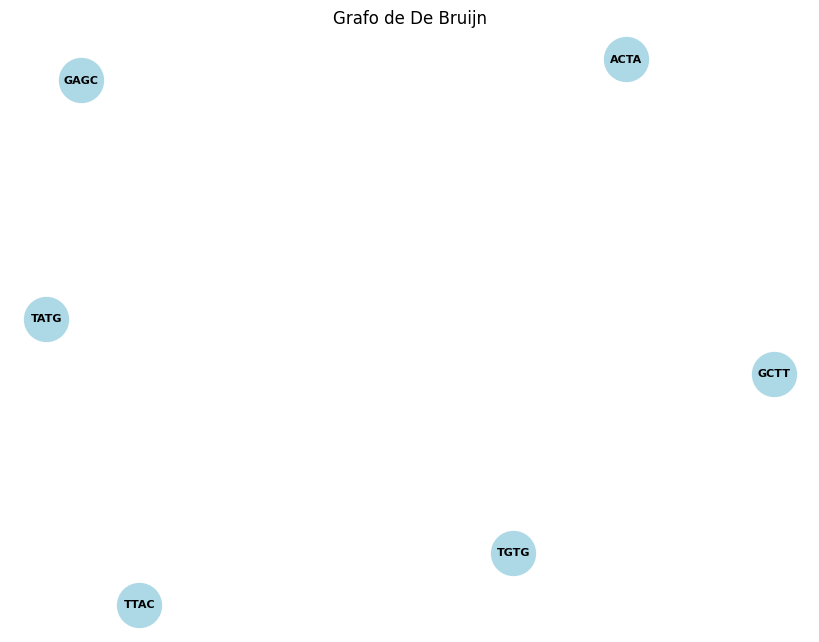

Não foi possível reconstruir o genoma (sem caminho euleriano).


In [35]:
g = Gerenciador_de_Genomas()
reads = ["GAGC", "GCTT", "TTAC", "ACTA", "TATG", "TGTG"]
kmers = reads # g.gerar_kmers(reads, k=4)
grafo = g.gerar_grafo_de_DeBruijn(kmers)
g.desenhar_grafo(grafo)

if  g.verificar_se_tem_caminho_euleriano(grafo):
    caminho = g.obter_caminho_euleriano(grafo)
    genoma_reconstruido = g.reconstruir_genoma(caminho)
    print("Genoma reconstruído:", genoma_reconstruido)
else:
    print("Não foi possível reconstruir o genoma (sem caminho euleriano).")

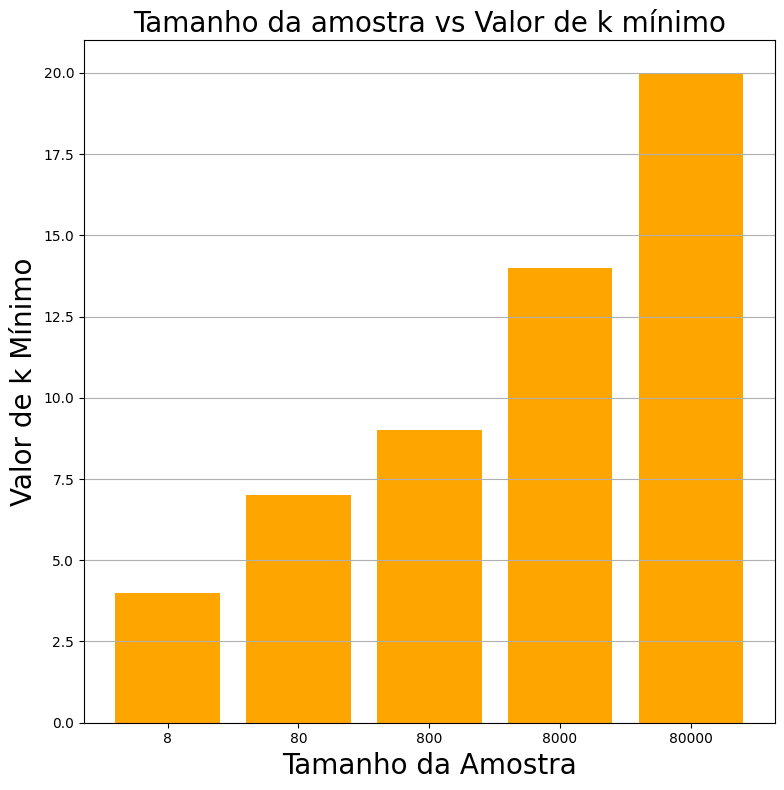

In [ ]:
import matplotlib.pyplot as plt

# Dados para o gráfico 1 (tempo vs tamanho da amostra)
tamanhos_amostra = [8, 80, 800, 8000, 80000]
tempos_execucao = [0.001, 0.0025, 0.0193, 1.3301, 242.57] 

# Dados para o gráfico 2 (tamanho vs k ideal)
k_ideal = [4, 7, 9, 14, 20]  # valores fictícios de k considerados ideais

# Criar a figura com 2 subgráficos
plt.figure(figsize=(15, 8))

# --- Gráfico 1: Linha ---
plt.subplot(1, 2, 1)
plt.plot(tamanhos_amostra, tempos_execucao, marker='o', color='blue', linewidth=2)
plt.title("Tempo de Execução vs Tamanho da Amostra (para k = 50% do tamanho do genoma)", fontsize=20)
plt.xlabel("Tamanho da Amostra", fontsize=20)
plt.ylabel("Tempo (s)", fontsize=20)
plt.xscale("log")  # Escala logarítmica no eixo x
plt.yscale("log")  # Escala log no eixo y
plt.grid(True)

# --- Gráfico 2: Barras ---
plt.subplot(1, 2, 2)
plt.bar([str(t) for t in tamanhos_amostra], k_ideal, color='orange')
plt.title("Tamanho da amostra vs Valor de k mínimo", fontsize=20)
plt.xlabel("Tamanho da Amostra", fontsize=20)
plt.ylabel("Valor de k Mínimo", fontsize=20)
plt.grid(axis='y')

# Ajustar o layout
plt.tight_layout()
plt.show()

In [90]:
len(genoma_real)

5386

In [101]:
manager = Gerenciador_de_Genomas()
def recombinacao_genetica2(genoma,tamanho_read,k,cobertura, temperatura):
    start = time.time()
    print(f"Tamanho do Genoma Original: {len(genoma)}")
    reads = manager.gerar_reads(genoma, tamanho_read,cobertura,temperatura)
    print(f"Foram gerados {len(reads)} reads de tamanho {tamanho_read}")
    kmers = manager.gerar_kmers(reads, k)
    print(f"Foram gerados {len(reads)} k-mers de tamanho {k}")
    grafo = manager.gerar_grafo_de_DeBruijn(kmers)
    if manager.verificar_se_tem_caminho_euleriano(grafo):
        caminho = manager.obter_caminho_euleriano(grafo)
        genoma1 = manager.reconstruir_genoma(caminho)
        print(f"Genoma final: {genoma1}")
        end = time.time()-start
        print(f"Tempo de execução: {round(end,4)} segundos")
        return grafo, genoma1, end
    else:
        print("O grafo não possui caminho Euleriano")

In [105]:
grafo, genoma_final, tempo = recombinacao_genetica2(genoma_real,120,80,0.7,10)

Tamanho do Genoma Original: 5386
Foram gerados 3686 reads de tamanho 120
Foram gerados 3686 k-mers de tamanho 80
Genoma final: GAGTTTTATCGCTTCCATGACGCAGAAGTTAACACTTTCGGATATTTCTGATGAGTCGAAAAATTATCTTGATAAAGCAGGAATTACTACTGCTTGTTTACGAATTAAATCGAAGTGGACTGCTGGCGGAAAATGAGAAAATTCGACCTATCCTTGCGCAGCTCGAGAAGCTCTTACTTTGCGACCTTTCGCCATCAACTAACGATTCTGTCAAAAACTGACGCGTTGGATGAGGAGAAGTGGCTTAATATGCTTGGCACGTTCGTCAAGGACTGGTTTAGATATGAGTCACATTTTGTTCATGGTAGAGATTCTCTTGTTGACATTTTAAAAGAGCGTGGATTACTATCTGAGTCCGATGCTGTTCAACCACTAATAGGTAAGAAATCATGAGTCAAGTTACTGAACAATCCGTACGTTTCCAGACCGCTTTGGCCTCTATTAAGCTCATTCAGGCTTCTGCCGTTTTGGATTTAACCGAAGATGATTTCGATTTTCTGACGAGTAACAAAGTTTGGATTGCTACTGACCGCTCTCGTGCTCGTCGCTGCGTTGAGGCTTGCGTTTATGGTACGCTGGACTTTGTGGGATACCCTCGCTTTCCTGCTCCTGTTGAGTTTATTGCTGCCGTCATTGCTTATTATGTTCATCCCGTCAACATTCAAACGGCCTGTCTCATCATGGAAGGCGCTGAATTTACGGAAAACATTATTAATGGCGTCGAGCGTCCGGTTAAAGCCGCTGAATTGTTCGCGTTTACCTTGCGTGTACGCGCAGGAAACACTGACGTTCTTACTGACGCAGAAGAAAACGTGCGTCAAAAATTACGTGCGGAAGGAGTGATGTAATGTCTAAAGGTAAAAAACGTTCTGG

In [107]:
manager.comparar_genormas(genoma_real,genoma_final)

1.0

In [106]:
manager.desenhar_grafo(grafo)

KeyboardInterrupt: 